# <b> Chapter 6

In [589]:
from decimal import Decimal, getcontext
from math import sqrt, pow, exp, erf, pi
from matplotlib.patches import Rectangle 
from matplotlib.lines import Line2D
from collections import Counter
import statistics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import enum
import random

TIMES = 10_000
random.seed(23)
getcontext().prec = 4

In [590]:
# Defining some decorators 


def rounder(val=2):
    def outer(fn):
        def inner(*args, **kwargs):
            res = fn(*args, **kwargs)
            return round(res, val)
        return inner
    return outer

def to_Decimal(fn):
    def inner(*args, **kwargs):
        args = [Decimal(arg) for arg in args]
        kwargs = {k:Decimal(v) for k, v in kwargs.items()}
        return Decimal(fn(*args, **kwargs))
    return inner

## Conditional Probability

In [591]:
# Calculating the probablity of children genders

# No girls -> 1/2 * 1/2 = 1/4
# Two girls -> 1/2 * 1/2 = 1/4. Same as above.
# One girl, one boy (vice-versa) -> 1/2 * 1/2 + 1/2 * 1/2 = 1/2.
# Both children are girls, given that at least one of them is a girl (conditional). 1/2 or 1/3 (two scenarios)


class Child(enum.IntEnum):
    BOY = 0
    GIRL = 1


def rand_child() -> Child:
    return random.choice([Child.BOY, Child.GIRL])


# The first has to be a boy as well as the second one
@rounder()
def no_girls() -> float:
    boy = 0
    girl = 0
    for _ in range(TIMES):
        if rand_child() == Child.BOY:
            boy += 1
        else:
            girl += 1
    # Probability of a boy given all scenarios.
    first_child = (boy / (boy + girl))
    return first_child * first_child  # Independent events


# Same as above
@rounder()
def two_girls() -> float:
    boy = 0
    girl = 0
    for _ in range(TIMES):
        if rand_child() == Child.BOY:
            boy += 1
        else:
            girl += 1
    # Probability of a boy given all scenarios.
    first_child = (girl / (boy + girl))
    return first_child * first_child  # Independent events


# The first can either be a girl or a boy (1/2*1/2), but the second must be a boy or a girl in that order.
@rounder()
def girl_boy() -> float:
    boy = 0
    girl = 0
    for _ in range(TIMES):
        first_child = rand_child()
        second_child = rand_child()
        if first_child == Child.BOY:
            boy += 1
            if second_child == Child.GIRL:
                girl += 1
        if first_child == Child.GIRL:
            girl += 1
            if second_child == Child.BOY:
                boy += 1

    boy_girl = (boy / (boy+girl)) * (girl / (boy + girl))  # Boy and girl
    girl_boy = (girl / (boy + girl)) * (boy / (boy+girl))  # Girl and boy
    return boy_girl + girl_boy

@rounder()
def girl_girl(mol=0) -> float:
    both_girls = 0
    older_girl = 0
    either_girl = 0
    for _ in range(TIMES):
        first_child = rand_child()
        second_child = rand_child()
        if first_child == Child.GIRL:
            older_girl += 1
        if first_child == Child.GIRL and second_child == Child.GIRL:
            both_girls += 1
        if first_child == Child.GIRL or second_child == Child.GIRL:
            either_girl += 1
    match mol:
        case 0: return both_girls / older_girl
        case 1: return  both_girls / either_girl


print(f'P(B) = {no_girls()}\nP(G) = {two_girls()}\nP(G,B) = {girl_boy()}\nP(B|L) = {girl_girl(0)}\nP(B|G) = {girl_girl(1)}')

P(B) = 0.26
P(G) = 0.24
P(G,B) = 0.5
P(B|L) = 0.51
P(B|G) = 0.33


## Bayes’s Theorem

\begin{gather*}
P(A\vert B) = \frac{{P(B\vert A) \cdot P(A)}}{{P(B)}}
\end{gather*}

\begin{gather*}
or
\end{gather*}

\begin{gather*}
P(A\vert B) = \frac{{P(B\vert A) \cdot P(B)}}{{(P(B\vert A) \cdot P(B)) + (P(B\vert ¬A) \cdot P(¬B))}}
\end{gather*}

Given a disease and a test that:
<ul>
<li>
Affects 1 for every 10.000 people
</li>
<li>
Has 98% of sensitivity (correctly identify those with the disease)
</li>
</ul>

<b> What is the probability that one that tested positive have a disease?  

In [592]:
def p_dt() -> float:
    """Calculates the probability that one that tested positive have a disease"""
    p_d = Decimal('1') / Decimal('10_000')
    p_notd = Decimal('1') - p_d 
    p_td = Decimal('0.98')
    p_tnotd = Decimal('1') - p_td
    return p_td * p_d / ((p_td * p_d) + (p_tnotd * p_notd))
    

print(f'P(D|T): {p_dt()}\nThat is, 99,952% of the positive tests are false positives\n(Test errors are relatively common - one in 100 - compared with cases of the disease).') 

P(D|T): 0.004876
That is, 99,952% of the positive tests are false positives
(Test errors are relatively common - one in 100 - compared with cases of the disease).


## Continuous Distribution

### There are two major functions in Uniform Distributions:

#### - Probability Density Function (PDF):

$$
\begin{gather*}
{\displaystyle f(x)={\begin{cases}{\frac {1}{b-a}}&{\text{for }}a\leq x\leq b,\\[8pt]0&{\text{for }}x<a\ {\text{ or }}\ x>b.\end{cases}}}
\end{gather*}
$$



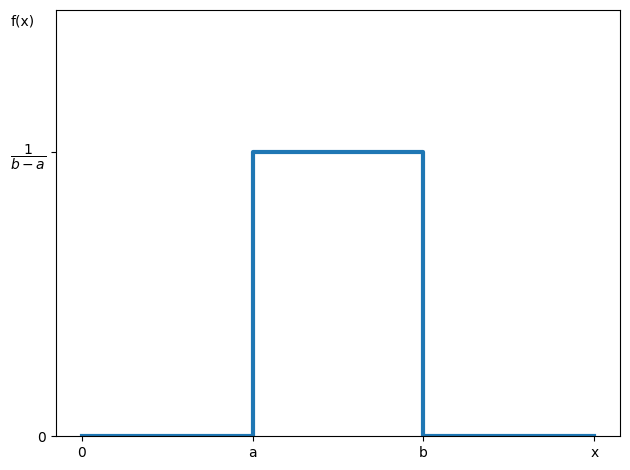

In [593]:
# Plotting the graph

x = ["0", "a", "a", "b", "b", "x"]
y = ["0", "0", r"$\dfrac{1}{b-a}$",  r"$\dfrac{1}{b-a}$", "0", "0"]
ax = plt.subplot()
ax.plot(x, y, linewidth=3)
ticklabelpad = matplotlib.rcParams['xtick.major.pad']
ax.annotate('f(x)', xy=(-0.1,1), xytext=(8, -ticklabelpad), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
plt.ylim(top=1.5, bottom=0)
plt.tight_layout(h_pad=-20)
plt.show()

#### - Cumulative Distribution Function:

$$
\begin{gather*}
{\displaystyle F(x)={\begin{cases}0&{\text{for }}x<a,\\[8pt]{\frac {x-a}{b-a}}&{\text{for }}a\leq x\leq b,\\[8pt]1&{\text{for }}x>b.\end{cases}}}
\end{gather*}
$$

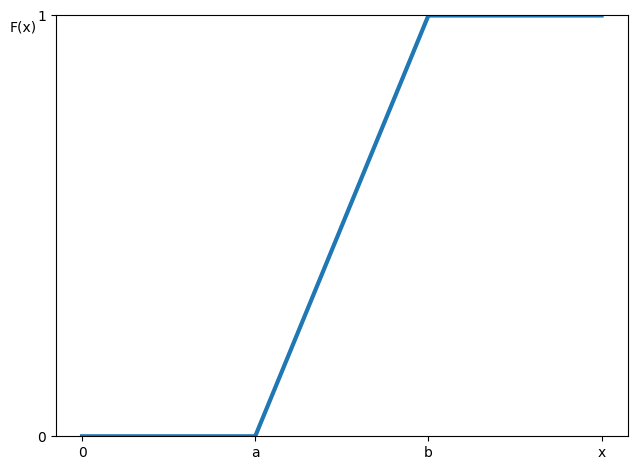

In [594]:
x = ["0", "a", "b", "x"]
y = ["0", "0", "1", "1"]
ax = plt.subplot()
ax.plot(x, y, linewidth=3)
ticklabelpad = matplotlib.rcParams['xtick.major.pad']
ax.annotate('F(x)', xy=(-0.1,1), xytext=(8, -ticklabelpad), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
plt.ylim(top=1, bottom=0)
plt.tight_layout(h_pad=-20)
plt.show()

#### ⭐ Real world-case example:

You have to wait for a bus that is uniformly late 2-10 minutes. In any given day, how long are you expected to wait for its arrival, and what's the Standard Deviation? Else, if the bus is 7 minutes late, what is the probability that you get late for work in any given day?       

In [595]:
# Lets calculate the mean, std and apply the CDF

@to_Decimal
def time_mean(a: float, b: float) -> Decimal:
    return (a + b) / 2

@to_Decimal
def sd_deviation(a: float, b: float) -> Decimal:
    if b < a:
        a, b = b, a
    return sqrt(pow(b - a, 2) / 12)

@to_Decimal
def uniform_cdf(a: float, b: float, x: float) -> Decimal:
    if b < a:
        a, b = b, a
    if x < a:
        return 0
    if x > b:
        return 1
    return (b - x) / (b - a)

a = 2
b = 10
x = 7
t_mean = time_mean(a, b)
t_dev = sd_deviation(a, b)
t_cdf = uniform_cdf(a, b, x)

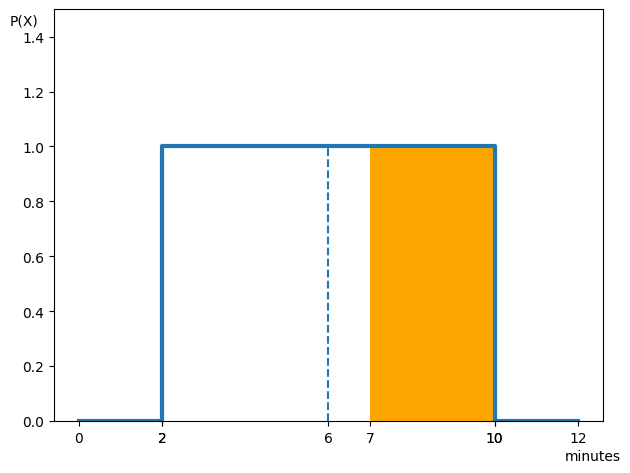

======= Bus lateness =======

Mean(μ): 6
STD(σ): 2.31
P([0, 2, 2, 6, 7, 10, 10, 12] <= X <= 10): 0.375



In [596]:
# Plotting the graph

x = [0, 2, 2, 6, 7, 10, 10, 12]
y = [0, 0, 1, 1, 1, 1, 0, 0]
ax = plt.subplot()
plt.xticks(x)
l = Line2D(xdata=[6, 6], ydata=[0, 1], linestyle='--')
ax.add_line(l)
ax.add_patch(Rectangle([7, 0], width=3, height=1, facecolor='orange'))
ax.plot(x, y, linewidth=3)
ticklabelpad = matplotlib.rcParams['xtick.major.pad']
ax.annotate('P(X)', xy=(-0.1,1), xytext=(8, -ticklabelpad), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
ax.annotate('minutes', xy=(0.91,-0.09), xytext=(8, -ticklabelpad), ha='left', va='bottom',
            xycoords='axes fraction', textcoords='offset points')
plt.ylim(top=1.5, bottom=0)
plt.tight_layout(h_pad=-20)

plt.show()
print(f"{'='*7} Bus lateness {'='*7}\n\nMean(μ): {t_mean}\nSTD(σ): {t_dev:.2f}\nP({x} <= X <= {b}): {t_cdf}\n\n{'='*28}")

## The Normal Distribution


#### - Probability Density Function (PDF):

$$
\begin{gather*}
{\displaystyle f(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}}
\end{gather*}
$$

#### - Generic Cumulative Distribution Function (CDF):

$$
\begin{gather*}
{\displaystyle F(x)=\Phi \left({\frac {x-\mu }{\sigma }}\right)={\frac {1}{2}}\left[1+\operatorname {erf} \left({\frac {x-\mu }{\sigma {\sqrt {2}}}}\right)\right]}
\end{gather*}
$$


#### - Inverse of CDF:

$$
\begin{gather*}
{\displaystyle x_{n+1}=x_{n}-{\frac {\Phi (x_{n},x_{0},\Phi (x_{0}))-\Phi (\mathrm {Desired} )}{\Phi '(x_{n})}}}
\end{gather*}

In [597]:
# Defining the functions


def normal_pdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    """Calculates the mean with the Probability Density Function for the Normal Distribution"""
    expo = exp(-pow((x - mu) / sigma, 2) / 2)
    return expo / (sigma * sqrt(2 * pi))


def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    """Calculates the accumulated proability with the Cumulative Distribution Function for the Normal Distribution"""
    return (1 + erf((x - mu) / (sigma * sqrt(2)))) / 2


# This is the author's code, not mine.
def inverse_normal_cdf(
    p: float, mu: float = 0, sigma: float = 1, tol: float = 0.00001) -> float:
    """Uses binary search for estimating the x obtained by the CDF that is needed for its calculation."""
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tol=tol)
    low_z = -10.0  # normal_cdf(-10) is (very close to) 0
    hi_z = 10.0  # normal_cdf(10) is (very close to) 1
    while hi_z - low_z > tol:
        mid_z = (low_z + hi_z) / 2  # Consider the midpoint
        mid_p = normal_cdf(mid_z)  # and the CDF's value there
        if mid_p < p:
            low_z = mid_z  # Midpoint too low, search above it
        else:
            hi_z = mid_z  # Midpoint too high, search below it
    return mid_z


xs = [x / 10 for x in range(-50, 51)]

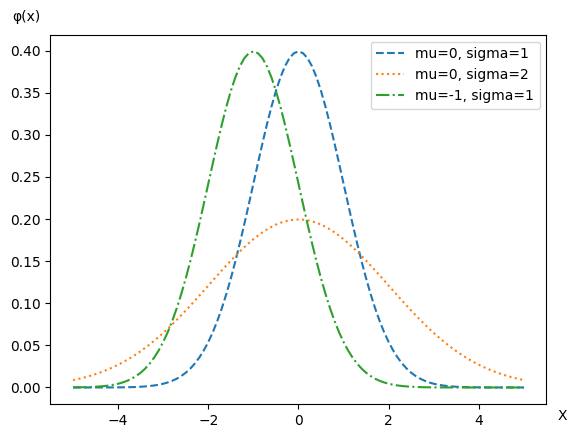

In [598]:
# Plotting a graph with normal pdfs


ax = plt.subplot()
plt.plot(xs, [normal_pdf(x) for x in xs], label='mu=0, sigma=1', linestyle='--') # Standard Normal Distribution
plt.plot(xs, [normal_pdf(x, sigma=2) for x in xs], label='mu=0, sigma=2', linestyle=':')
plt.plot(xs, [normal_pdf(x, mu=-1) for x in xs], label='mu=-1, sigma=1', linestyle='-.')
ax.annotate('φ(x)', xy=(-0.1,1.08), xytext=(8, -ticklabelpad), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
ax.annotate('X', xy=(1,0), xytext=(8, -ticklabelpad), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
plt.legend()
plt.show()

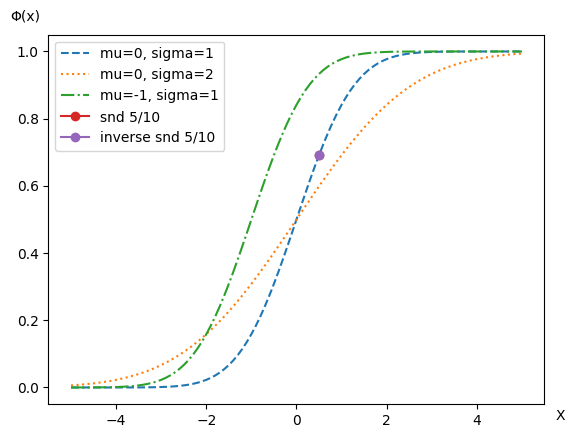

In [599]:
# Plotting a graph with normal cdfs


ax = plt.subplot()
plt.plot(xs, [normal_cdf(x) for x in xs], label='mu=0, sigma=1', linestyle='--') # Standard Normal Distribution
plt.plot(xs, [normal_cdf(x, sigma=2) for x in xs], label='mu=0, sigma=2', linestyle=':')
plt.plot(xs, [normal_cdf(x, mu=-1) for x in xs], label='mu=-1, sigma=1', linestyle='-.')

# Picking the x = 5/10 and finding its probability for the inverse cdf
x = 5/10
px = normal_cdf(x)
plt.plot(x, px, marker='o', label='snd 5/10')
plt.plot(inverse_normal_cdf(px), px, marker='o', label='inverse snd 5/10')

ax.annotate('Φ(x)', xy=(-0.1,1.08), xytext=(8, -ticklabelpad), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
ax.annotate('X', xy=(1,0), xytext=(8, -ticklabelpad), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
plt.legend()
plt.show()

#### ⭐ Real world-case example:

The Embrapa calculates that the optimal level of calcium should be around 1.60 to 3.00 cmolc/dm3. A group of researches collected samples of soil in a 10 heactare Morrinhos land and  discovered that the Ca2+ is normally distributed with μ = 1.44 cmolc/dm3. and σ = 1.62 cmolc/dm3. Supposing that the probability of finding optimal soil corresponds to the percentage of optimum soil, how much of that farm is considered to be arable?

<b> NOTE: the graph above is merely ilustrative. In the lack of proper data, there are lots of negative samples, which is , naturally, not possible.   </b>

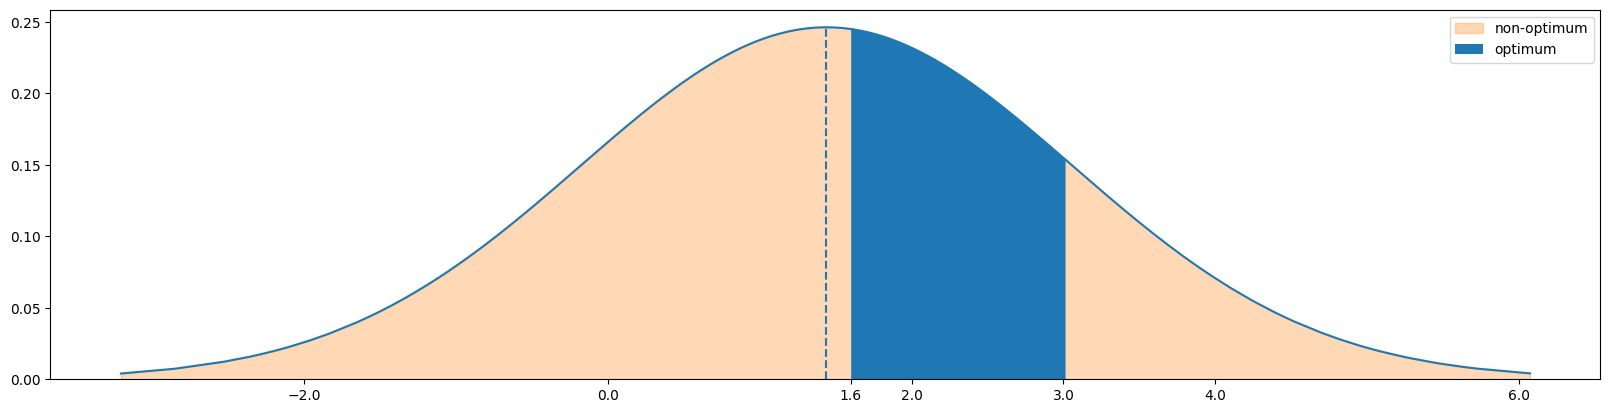

In [600]:
# Plotting the non standardized graph.


mu = 1.44
sigma = 1.62
sample_size = 500  # Its better to use larger samples for visualization of the mu line
xs = np.array(sorted(statistics.NormalDist(mu, sigma).samples(sample_size)))
ys = np.array([normal_pdf(x, mu=mu, sigma=sigma) for x in xs])
i_min = np.argmax(xs >= 1.60)
i_max = np.argmax(xs >= 3.02)  # Using 3.02 just for aesthetics
optimum_freq = xs[i_min:i_max], ys[i_min:i_max]
plt.figure().set_figwidth(20)
plt.plot(xs, ys)
plt.plot([mu, mu], [0, normal_pdf(mu, mu=mu, sigma=sigma)], linestyle="--", color="C0")
plt.xticks(list(plt.xticks()[0]) + [1.6, 3.00])
plt.fill_between(xs, ys, label="non-optimum", color="C1", alpha=0.3)
plt.fill_between(*optimum_freq, label="optimum")
plt.legend()
plt.ylim(bottom=0)
plt.show()

In [601]:
# Performing the calculations

cdf = lambda x: normal_cdf(x, mu=mu, sigma=sigma)

# The question can be answered by calculating the dif. between the sum of the non optimum accumulated probabilities and 1.

percent_area = 1 - ((1 - cdf(3)) + cdf(1.6))
print(f'Arable land: {percent_area * 100 :.1f}%')

Arable land: 29.3%


## The Central Limit Theorem

\begin{gather*}
{\displaystyle {\bar {X}}_{n}\equiv {\frac {X_{1}+\cdots +X_{n}}{n}}.}
\end{gather*}

#### So, to test the Central Limit Theorem, lets create a uniform distribution consisting of random numbers, get s samples of that space and calculate the mean, then plot it in a histogram.

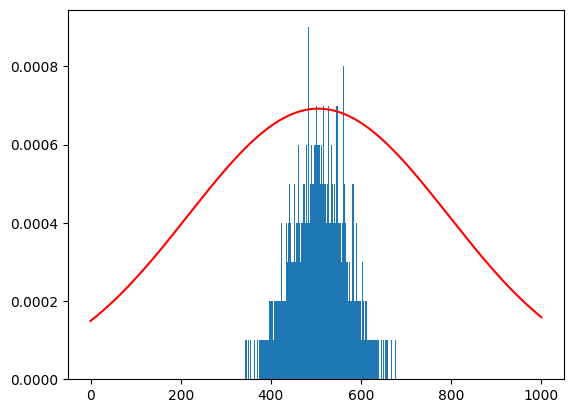

Mean of the sample space: 504.8448
Mean of the samples: 505.33154


In [636]:
ss = 10_000
s = 75
n = 35
sample_space = [int(np.random.randint(0, 1001)) for _ in range(ss)]
samples = [statistics.mean([random.choice(sample_space) for _ in range(n)]) for _ in range(ss)]

mu = statistics.mean(sample_space)
sigma = statistics.stdev(sample_space)

# Plotting the histogram

histogram = Counter(samples)
plt.bar([x for x in histogram.keys()], [y / ss for y in histogram.values()])  # Corrected scaling factor to ss
xs = range(min(sample_space), max(sample_space) + 1)
ys = [normal_cdf(x, mu, sigma) - normal_cdf(x - 0.5, mu, sigma) for x in xs]  # Corrected calculation of ys

plt.plot(xs, ys, color='r')
plt.show()

print(f'Mean of the sample space: {statistics.mean(sample_space)}\nMean of the samples: {statistics.mean(samples)}')